In [1]:
from jde import *
import sys
sys.path.append('../../')
from opts import opts
import torch
from PIL import Image
import cv2

In [47]:
class JointDataset_test(LoadImagesAndLabels):  # for training
    default_resolution = [1088, 608]
    mean = None
    std = None
    num_classes = 1

    def __init__(self, opt, root, paths, img_size=(1088, 608), augment=False, transforms=None):
        self.opt = opt
        dataset_names = paths.keys()
        self.img_files = OrderedDict()
        self.label_files = OrderedDict()
        self.tid_num = OrderedDict()
        self.tid_start_index = OrderedDict()
        self.num_classes = 1

        for ds, path in paths.items():
            with open(path, 'r') as file:
                self.img_files[ds] = file.readlines()
                self.img_files[ds] = [osp.join(root, x.strip()) for x in self.img_files[ds]]
                self.img_files[ds] = list(filter(lambda x: len(x) > 0, self.img_files[ds]))

            self.label_files[ds] = [
                # x.replace('images', 'labels_with_ids_both').replace('.png', '.txt').replace('.jpg', '.txt')
                x.replace('images', 'labels_with_ids_both_vh').replace('.png', '.txt').replace('.jpg', '.txt')
                for x in self.img_files[ds]]
            
            fucking_ids = self.label_files[ds].index('/data/mot/crowdhuman/labels_with_ids_both_vh/train/283647,18df9000aa5f67ce.txt')
        

        freak_labels = []
        for ds, label_paths in self.label_files.items():
            max_index = -1
            print(label_paths[fucking_ids])
            label_paths = list(label_paths)
            for lp in label_paths:
                if lp in '/data/mot/crowdhuman/labels_with_ids_both_vh/train/283647,18df9000aa5f67ce.txt':
                    print('got cha')

                lb = np.loadtxt(lp)
                if len(lb) < 1:
                    continue
                if len(lb.shape) < 2:
                    img_max = lb[1]
                    lb = np.expand_dims(lb, axis=0)
                else:
                    img_max = np.max(lb[:, 1])

                n_obj = len(lb)
                if n_obj > self.opt.K:
                    self.label_files[ds].remove(lp)
                    # img_path = lp.replace('labels_with_ids_both', 'images').replace('.txt', '.png').replace('.txt', '.jpg')
                    img_path = lp.replace('labels_with_ids_both_vh', 'images').replace('.txt', '.png')
                    try :
                        self.img_files[ds].remove(img_path)
                    except  :
                        img_path = img_path.replace('.png', '.jpg')
                        self.img_files[ds].remove(img_path)
                    # print(f"Objects in image {lp} exceeds {opt.K}. excluded {img_path} image & label")
                    freak_labels.append(lp)
                    continue


                if img_max > max_index:
                    max_index = img_max

            self.tid_num[ds] = max_index + 1
        print(f'The number of Freaked data : {len(freak_labels)}')
        last_index = 0
        for i, (k, v) in enumerate(self.tid_num.items()):
            self.tid_start_index[k] = last_index
            last_index += v

        self.nID = int(last_index + 1)
        self.nds = [len(x) for x in self.img_files.values()] # [number of samples in first dataset, n_second dataset]
        self.cds = [sum(self.nds[:i]) for i in range(len(self.nds))] # [0, number of samples in first dataset]
        self.nF = sum(self.nds)
        self.width = img_size[0]
        self.height = img_size[1]
        self.max_objs = opt.K
        self.augment = augment
        self.transforms = transforms

        print('=' * 80)
        print('dataset summary')
        print(self.tid_num)
        print('total # identities:', self.nID)
        print('start index')
        print(self.tid_start_index)
        print('=' * 80)

        

    def preprocess_before_get(self, ids_arr, bbox_arr, output_h, output_w, num_classes=1):

        hm = np.zeros((num_classes, output_h, output_w), dtype=np.float32)
        if self.opt.ltrb:
            wh = np.zeros((self.max_objs, 4), dtype=np.float32)
        else:
            wh = np.zeros((self.max_objs, 2), dtype=np.float32)
        reg = np.zeros((self.max_objs, 2), dtype=np.float32)
        ind = np.zeros((self.max_objs,), dtype=np.int64)
        reg_mask = np.zeros((self.max_objs,), dtype=np.uint8)
        ids = np.zeros((self.max_objs,), dtype=np.int64)
        bbox_xys = np.zeros((self.max_objs, 4), dtype=np.float32)

        draw_gaussian = draw_msra_gaussian if self.opt.mse_loss else draw_umich_gaussian

        num_objs = ids_arr.shape[0]
        # print(f'ids_arr : {ids_arr.shape[0]}, bbox_arr shape : {bbox_arr.shape}')
        for k in range(num_objs):
            # label = labels[k]
            bbox = bbox_arr[k]
            cls_id = 0
            bbox[[0, 2]] = bbox[[0, 2]] * output_w
            bbox[[1, 3]] = bbox[[1, 3]] * output_h
            bbox_amodal = copy.deepcopy(bbox)

            bbox_amodal[0] = bbox_amodal[0] - bbox_amodal[2] / 2.
            bbox_amodal[1] = bbox_amodal[1] - bbox_amodal[3] / 2.
            bbox_amodal[2] = bbox_amodal[0] + bbox_amodal[2]
            bbox_amodal[3] = bbox_amodal[1] + bbox_amodal[3]
            bbox[0] = np.clip(bbox[0], 0, output_w - 1)
            bbox[1] = np.clip(bbox[1], 0, output_h - 1)
            h = bbox[3]
            w = bbox[2]
            bbox_xy = copy.deepcopy(bbox)
            bbox_xy[0] = bbox_xy[0] - bbox_xy[2] / 2
            bbox_xy[1] = bbox_xy[1] - bbox_xy[3] / 2
            bbox_xy[2] = bbox_xy[0] + bbox_xy[2]
            bbox_xy[3] = bbox_xy[1] + bbox_xy[3]

            if h > 0 and w > 0:
                radius = gaussian_radius((math.ceil(h), math.ceil(w)))
                radius = max(0, int(radius))
                radius = 6 if self.opt.mse_loss else radius
                #radius = max(1, int(radius)) if self.opt.mse_loss else radius
                ct = np.array(
                    [bbox[0], bbox[1]], dtype=np.float32)
                ct_int = ct.astype(np.int32)
                draw_gaussian(hm[cls_id], ct_int, radius)
                if self.opt.ltrb:
                    # distance from center to lt, from center to rb (w1,h1, w2,h2)
                    wh[k] = ct[0] - bbox_amodal[0], ct[1] - bbox_amodal[1], \
                            bbox_amodal[2] - ct[0], bbox_amodal[3] - ct[1]
                else:
                    wh[k] = 1. * w, 1. * h
                ind[k] = ct_int[1] * output_w + ct_int[0]
                reg[k] = ct - ct_int
                reg_mask[k] = 1
                ids[k] = ids_arr[k]
                bbox_xys[k] = bbox_xy

                # print(f'output_w : {output_w}, output_h : {output_h}, ct : {ct}, ct_int : {ct_int}')
                # print(f'ind : {ind}, ind[k] : {ct_int[1] * output_w + ct_int[0]}')


        return hm, reg_mask, ind, wh, reg, ids, bbox_xys

    def __getitem__(self, files_index):

        for i, c in enumerate(self.cds):
            if files_index >= c:
                ds = list(self.label_files.keys())[i]
                start_index = c

        img_path = self.img_files[ds][files_index - start_index]
        label_path = self.label_files[ds][files_index - start_index]

        imgs, labels, img_path, (input_h, input_w) = self.get_data(img_path, label_path)
        for i, _ in enumerate(labels):
            if labels[i, 1] > -1:
                labels[i, 1] += self.tid_start_index[ds]

        output_h = imgs.shape[0] // self.opt.down_ratio
        output_w = imgs.shape[1] // self.opt.down_ratio

        num_classes = self.num_classes
        num_objs = labels.shape[0]
        
        head_hm, head_reg_mask, head_ind, head_wh, head_reg, _, head_bbox_xys = self.preprocess_before_get(labels[:, 1], labels[:, 2:6], output_h, output_w )
        full_hm, full_reg_mask, full_ind, full_wh, full_reg, ids, full_bbox_xys = self.preprocess_before_get(labels[:, 1], labels[:, 6:10], output_h, output_w)

        ret = {'input': imgs,
               'head_hm': head_hm,
               'head_reg_mask': head_reg_mask,
               'head_ind': head_ind,
               'head_wh': head_wh,
               'head_reg': head_reg,
               'ids': ids,
               'head_bbox': head_bbox_xys,
               'full_hm' : full_hm,
               'full_reg_mask' : full_reg_mask,
               'full_ind' : full_ind,
               'full_wh' : full_wh,
               'full_reg' : full_reg,
               'full_bbox' : full_bbox_xys
               }
        return ret
#         return {'images' : imgs, 'labels' : labels, 'img_path' : img_path, 'output_hw' : (output_h, output_w)}


In [3]:
data_config = {
    "root":"/data/mot",
    "train":
    {
        "crowdhuman_train":"../../../data/crowdhuman.train"
    },
    "valid":
    {
        "crowdhuman_test":"./data/crowdhuman.val"
    },
    "test_emb":
    {
        "mot15":"./data/mot15.val"
    },
    "test":
    {
        "mot15":"./data/mot15.val"
    }
}

In [4]:
#     data_config = json.load(f)
trainset_paths = data_config['train']
validset_paths = data_config['valid']
dataset_root = data_config['root']

In [5]:
opt = opts().parse(args = "mot --exp_id crowdhuman_dla34 --gpus 0,1,2,3  --batch_size 8 --num_iters -1  --num_epochs 30 --load_model '/data/models/mot/fairmot/crowdhuman_dla34/model_30.pth'  --lr_step 50 --data_cfg '../src/lib/cfg/crowdhuman.json'".split())

Fix size testing.
training chunk_sizes: [2, 2, 2, 2]
The output will be saved to  /data/models/mot/fairmot/crowdhuman_dla34


In [48]:
byungsin = JointDataset_test(opt, dataset_root, trainset_paths, (1088, 608), augment=False)

/data/mot/crowdhuman/labels_with_ids_both_vh/train/283647,18df9000aa5f67ce.txt
got cha
The number of Freaked data : 1190
dataset summary
OrderedDict([('crowdhuman_train', 339565.0)])
total # identities: 339566
start index
OrderedDict([('crowdhuman_train', 0)])


In [10]:
# byungsin = JointDataset(opt, dataset_root, trainset_paths, (1088, 608), augment=True)

The number of Freaked data : 1190
dataset summary
OrderedDict([('crowdhuman_train', 339565.0)])
total # identities: 339566
start index
OrderedDict([('crowdhuman_train', 0)])


## K filter를 위해선 반드시 ordereddict를 list로 바꿔줘야한다!

In [33]:
label_paths.index('/data/mot/crowdhuman/labels_with_ids_both_vh/train/283647,18df9000aa5f67ce.txt')

3667

In [34]:
'283647,18df9000aa5f67ce' in label_paths[3667]

True

# before get test

In [49]:
train_loader = torch.utils.data.DataLoader(
    byungsin,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)
iterer = iter(train_loader)

In [50]:
batch = next(iterer)

h : 20.900009155273438, w : 25.649898529052734

h : 12.983390808105469, w : 12.349899291992188

h : 13.61661148071289, w : 10.766677856445312

h : 12.349998474121094, w : 10.766670227050781

h : 11.71661376953125, w : 9.8167724609375

h : 11.71661376953125, w : 9.816757202148438

h : 12.666618347167969, w : 12.666671752929688

h : 36.73338317871094, w : 25.649887084960938

h : 25.01660919189453, w : 22.483245849609375

h : 20.266618728637695, w : 18.366683959960938

h : 12.983383178710938, w : 13.933334350585938

h : 36.41661834716797, w : 29.76665496826172

h : 19.95000457763672, w : 15.516769409179688

h : 19.316612243652344, w : 13.616546630859375

h : 14.883384704589844, w : 14.249900817871094

h : 20.900009155273438, w : 25.649898529052734

h : 12.983390808105469, w : 12.349899291992188

h : 13.61661148071289, w : 10.766677856445312

h : 12.349998474121094, w : 10.766670227050781

h : 11.71661376953125, w : 9.8167724609375

h : 11.71661376953125, w : 9.816757202148438

h : 12.6666

In [84]:
batch.keys()

dict_keys(['images', 'labels', 'img_path', 'input_hw'])

---------

In [112]:
sample_label = batch['labels'][0]
sample_heght, sample_width = batch['input_hw']
# whwh_arr = np.asarray((sample_width.numpy(), sample_heght.numpy(), sample_width.numpy(), sample_heght.numpy())).reshape(4)
whwh_arr = np.asarray((byungsin.width, byungsin.height,byungsin.width, byungsin.height))

In [114]:
sample_img_ = sample_img.copy()

for obj_coords in sample_label:
#     ltrb = obj_coords[2:6]
#     head_lt = ltrb[0:2]
#     head_rb = ltrb[2:4]
    head_xywh = obj_coords[2:6]
    head_xywh = head_xywh * whwh_arr
    head_lt = head_xywh[:2] - (head_xywh[2:4]/2.)
    head_rb = head_xywh[:2] + (head_xywh[2:4]/2.)
    head_lt = tuple(map(int, head_lt))
    head_rb = tuple(map(int, head_rb))
#     sample_img_[head_lt[1] : head_lt[1]+5,  head_lt[0] : head_lt[0]+5] = (255,0,0)
    cv2.rectangle(sample_img_, head_lt ,head_rb, color=(255,0,0))

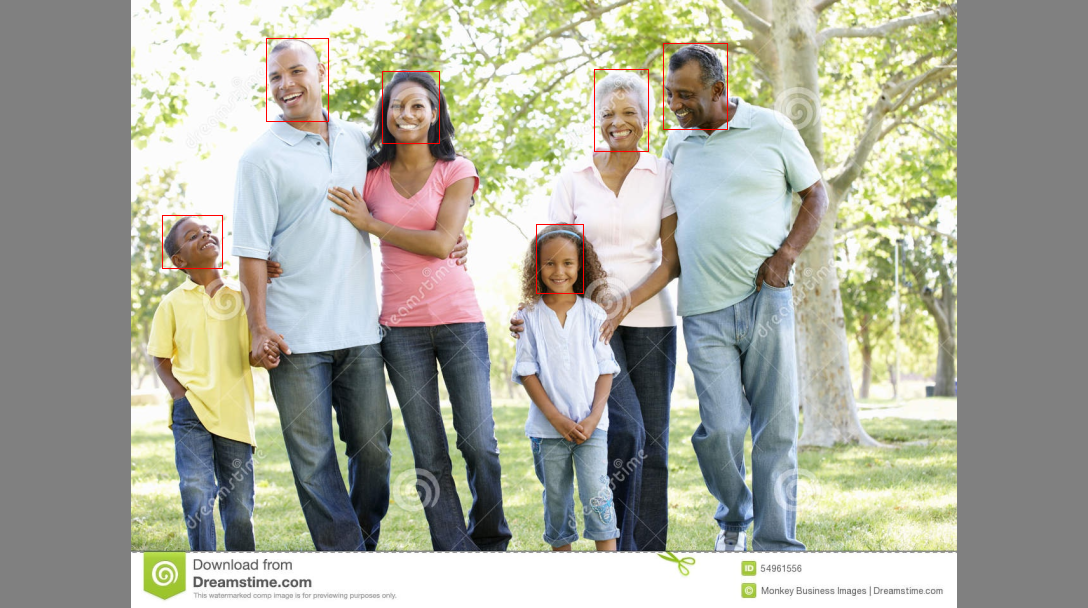

In [115]:
Image.fromarray(sample_img_)

--------

----------

In [38]:
 batch['images'].shape

torch.Size([1, 608, 1088, 3])

In [9]:
imgs = batch['images'].numpy()
labels = batch['labels'].numpy()
img_path = batch['img_path']
output_h, output_w = batch['output_hw']

In [148]:
# output_h = imgs.shape[1] // byungsin.opt.down_ratio
# output_w = imgs.shape[2] // byungsin.opt.down_ratio
# num_classes = byungsin.num_classes
# num_objs = labels.shape[0]

In [13]:
labels.shape

(1, 46, 10)

In [29]:
bbox = labels[0][3][2:6]

In [30]:
bbox

array([0.2970321 , 0.580183  , 0.02695777, 0.05475898], dtype=float32)

In [34]:
output_h.numpy()

array([272])

In [31]:
bbox[[0, 2]] = bbox[[0, 2]] * output_w.numpy()
bbox[[1, 3]] = bbox[[1, 3]] * output_h.numpy()

In [32]:
bbox

array([  0.      , 157.80978 ,   0.      ,  14.894442], dtype=float32)

In [123]:
batch['full_hm']

tensor([], size=(1, 1, 272, 0))

In [121]:
batch['head_wh']

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
 

In [122]:
batch['full_wh']

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
 